In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
import ase
from ase import Atoms
from ase.optimize import FIRE
from ase.io import read,write
from ase.constraints import FixAtoms

In [3]:
from copy import deepcopy

In [4]:
from matplotlib import cm

In [5]:
import cace
from cace.representations.cace_representation import Cace

In [6]:
from cace.tools import to_numpy

In [8]:
from cace.calculators import CACECalculator

In [28]:
dir_now = './fit-Au-MgO-Al-sr/'
#dir_now = './fit-Au-MgO-Al/'

In [29]:
calculator = CACECalculator(model_path=dir_now+'best_model.pth',
                            device='cpu', 
                            energy_key='CACE_energy', 
                            forces_key='CACE_forces',
                            #atomic_energies={8: -18599.43617104475, 12: -8721.75974245582, 13: -9877.676428588728, 79: -688.8680063349827},
                           compute_stress=False)

In [12]:
atomic_energies={8: -18599.43617104475, 12: -8721.75974245582, 13: -9877.676428588728, 79: -688.8680063349827}

In [12]:
# 1: non-wetting
# 3: wetting

In [14]:
for configs in ['1-doped', '3-doped', '1-undoped', '3-undoped']:
    test_xyz = ase.io.read('./dft-optimized-struct/'+configs+'.xyz', '0')
    energy_offset = 0.0
    atomic_numbers = test_xyz.get_atomic_numbers()
    energy_offset -= sum(atomic_energies.get(Z, 0) for Z in atomic_numbers)
    print(configs, "DFT energy:", test_xyz.info['energy'] + energy_offset)

    substrate_index = [atom.index for atom in test_xyz if atom.symbol in ['Mg', 'O', 'Al']]
    au_index = [atom.index for atom in test_xyz if atom.symbol in ['Au']]

    atoms = deepcopy(test_xyz)

    # relax
    atoms.set_calculator(calculator)


    c = FixAtoms(indices=substrate_index)

    atoms.set_constraint(c)


    # Perform geometry optimization
    opt = FIRE(atoms, logfile=None)

    run = opt.run(fmax=0.01, steps=500)  # Adjust fmax yfor convergence criteria

    write(dir_now+'relaxated-'+configs+'.xyz', atoms)

    print(configs, "CACE energy:", atoms.get_potential_energy()[0])
    print("--")

1-doped DFT energy: -0.8413328193128109
1-doped CACE energy: -0.8671999
--
3-doped DFT energy: -0.9082728298380971
3-doped CACE energy: -0.9377692
--
1-undoped DFT energy: -1.3590977899730206
1-undoped CACE energy: -1.4050766
--
3-undoped DFT energy: -0.4242778222542256
3-undoped CACE energy: -0.47373503
--


In [16]:
-0.9082728298380971 - -0.8413328193128109

-0.0669400105252862

In [17]:
 -0.9377692 - -0.8671999

-0.07056929999999995

In [18]:
-1.3590977899730206 - -0.4242778222542256

-0.9348199677187949

In [19]:
-1.4050766 - -0.47373503

-0.9313415699999998

In [81]:
doped1_xyz[0].arrays['q_scaled'].mean()

-0.009622252999999999

In [82]:
num='3'

doped1_xyz = ase.io.read(dir_now+'q-relaxated-'+num+'-doped.xyz', ':')
undoped1_xyz = ase.io.read(dir_now+'q-relaxated-'+num+'-undoped.xyz', ':')


q_dif = doped1_xyz[0].arrays['initial_charges'] - undoped1_xyz[0].arrays['initial_charges']

doped1_xyz[0].set_array('dope_charge_dif', q_dif)

q_dif = doped1_xyz[0].arrays['q_scaled'] - undoped1_xyz[0].arrays['q_scaled']

doped1_xyz[0].set_array('dope_q_scaled_dif', q_dif)

write(dir_now+'q-relaxated-'+num+'-doped.xyz', doped1_xyz[0])

In [30]:
dis_e_list = []
max_step = 40
for i in range(max_step):
    atoms = read(dir_now+'relaxated-1-undoped.xyz','0')
    atoms.set_calculator(calculator)
    displacement = (i - max_step/2) * 0.01
    atoms.positions[au_index, 2] += displacement
    AuO_dis = 10.58354436 - atoms.positions[108,2]
    dis_e_list.append([AuO_dis, atoms.get_potential_energy()[0]])

In [31]:
dis_e_list_doped = []
max_step = 40
for i in range(max_step):
    atoms = read(dir_now+'relaxated-1-doped.xyz','0')
    atoms.set_calculator(calculator)
    displacement = (i - max_step/2) * 0.01
    atoms.positions[au_index, 2] += displacement
    AuO_dis = 10.58354436 - atoms.positions[108,2] 
    dis_e_list_doped.append([AuO_dis, atoms.get_potential_energy()[0]])

In [32]:
dis_e_list = np.array(dis_e_list)
dis_e_list_doped = np.array(dis_e_list_doped)

In [26]:
result_undoped = {}
result_doped = {}

In [33]:
result_undoped['sr'] = dis_e_list
result_doped['sr'] = dis_e_list_doped

In [27]:
result_undoped['lr'] = dis_e_list
result_doped['lr'] = dis_e_list_doped

In [35]:
# Save the dictionary with numpy arrays
np.savez('energy-bondlength-undoped.npz', **result_undoped)
np.savez('energy-bondlength-doped.npz', **result_doped)

# To load the dictionary back
#loaded_data = np.load('data_file.npz')

In [21]:
configs = '1-doped'
atoms = ase.io.read('./dft-optimized-struct/'+configs+'.xyz', '0')
10.58354436 - atoms.positions[108,2] 

2.329964689999999

In [22]:
configs = '1-undoped'
atoms = ase.io.read('./dft-optimized-struct/'+configs+'.xyz', '0')
10.58354436 - atoms.positions[108,2] 

2.1883280099999993

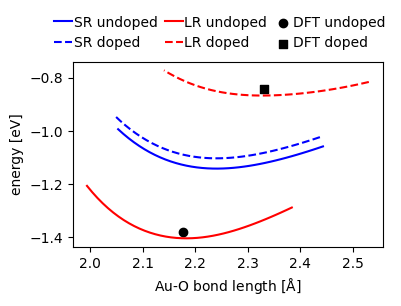

In [51]:
fig, ax = plt.subplots(figsize=(4, 2.4))

ax.plot(result_undoped['sr'][:,0], result_undoped['sr'][:,1], 'b-', label='SR undoped')
ax.plot(result_doped['sr'][:,0], result_doped['sr'][:,1],'b--', label='SR doped')

ax.plot(result_undoped['lr'][:,0], result_undoped['lr'][:,1], 'r-', label='LR undoped')
ax.plot(result_doped['lr'][:,0], result_doped['lr'][:,1],'r--', label='LR doped')

ax.scatter([2.177], [-1.3794519070070237], marker='o',c='k', label='DFT undoped') # DFT undoped
ax.scatter([2.332], [-0.8419586813542992], marker='s', c='k', label='DFT doped') #DFT doped

ax.set_xlabel('Au-O bond length [$\mathrm{\AA}$]')
ax.set_ylabel('energy [eV]')

ax.legend(ncol=3, fontsize=10, bbox_to_anchor=(1.05, 1.32),columnspacing=0.5, frameon=False,handlelength=1.3, handletextpad=0.1)


fig.savefig('Au-MgO-energy.pdf', dpi=300,
            bbox_inches='tight', 
               transparent=True,)